In [3]:
import pandas as pd
import numpy as np
df = pd.read_csv("./archive (4)/UrbanSound8K.csv")
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [4]:
import os
import librosa
import librosa.display

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

In [6]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout

In [16]:
# Audio Playback (Optional)
import IPython.display as ipd

# Resampling Library
import resampy  

from tqdm.auto import tqdm

In [7]:
dat1, sampling_rate1 = librosa.load('./archive (4)/fold5/100032-3-0-0.wav')
dat2, sampling_rate2 = librosa.load('./archive (4)/fold5/100263-2-0-117.wav')

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

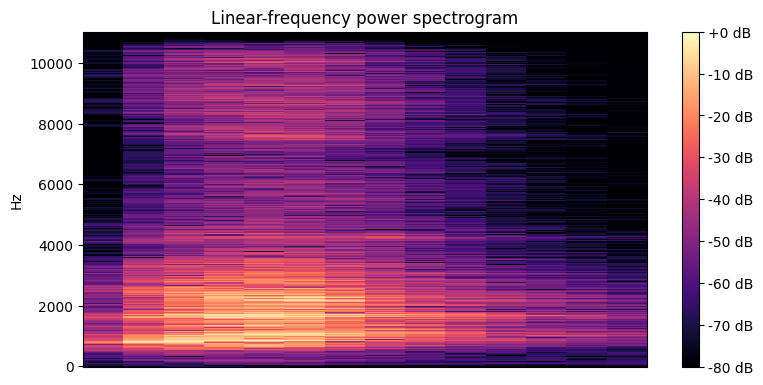

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Register Matplotlib Converters for Time Series Plots
pd.plotting.register_matplotlib_converters()
%matplotlib inline  
plt.figure(figsize=(20, 20))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat1)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

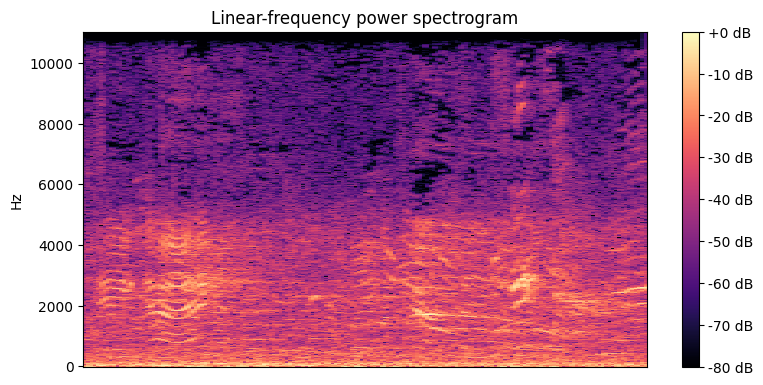

In [12]:
plt.figure(figsize=(20, 20))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat2)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

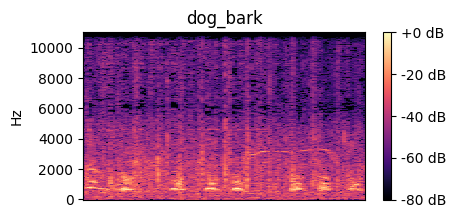

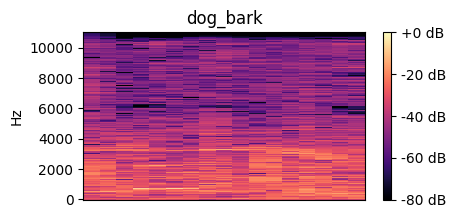

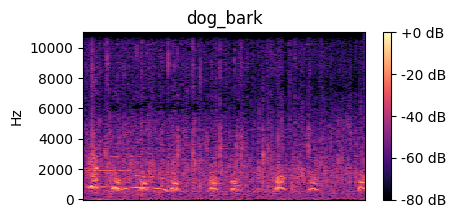

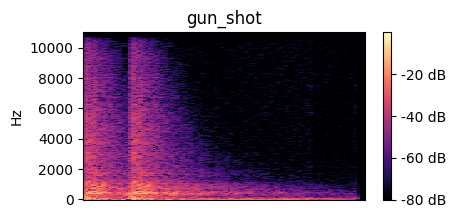

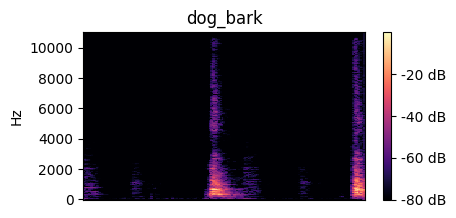

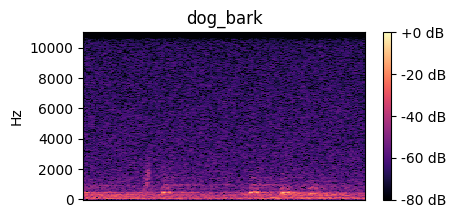

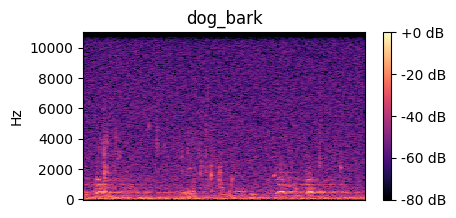

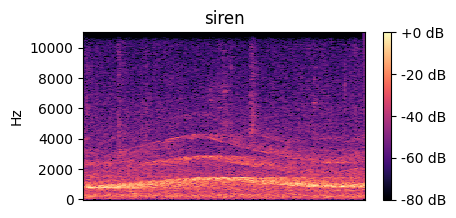

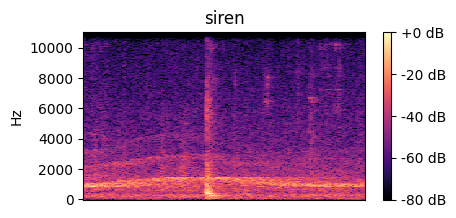

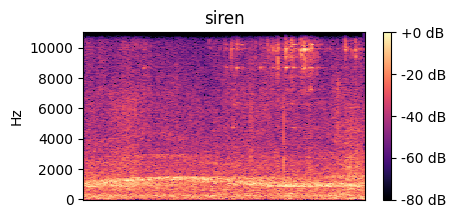

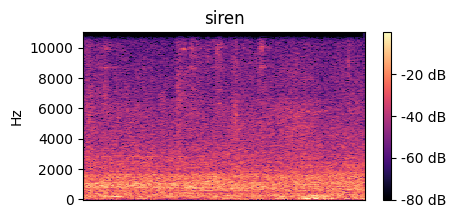

In [13]:
arr = np.array(df["slice_file_name"])
fold = np.array(df["fold"])
cla = np.array(df["class"])

for i in range(100, 121, 2):
    path = './archive (4)/fold' + str(fold[i]) + '/' + arr[i]
    data, sampling_rate = librosa.load(path)
    plt.figure(figsize=(10, 10))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    plt.subplot(4, 2, 1)
    librosa.display.specshow(D, y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title(cla[i])

In [14]:
# First restart kernel 
print("Librosa version:", librosa.__version__)
print("Resampy version:", resampy.__version__)

Librosa version: 0.10.2.post1
Resampy version: 0.4.3


In [22]:
def features_extract(file_name):
    sample, sample_rate = librosa.load(file_name, sr=None)  # Avoid resampling
    feature = librosa.feature.mfcc(y=sample, sr=sample_rate, n_mfcc=50, n_fft=1024)
    scaled_feature = np.mean(feature.T, axis=0)
    return scaled_feature

extracted = []
path = './archive (4)'

for index_num, row in tqdm(df.iterrows()):
    file_name = os.path.join(os.path.abspath(path), 'fold' + str(row["fold"]), str(row['slice_file_name'])) 
    final_class_labels = row['class']   
    data = features_extract(file_name)    
    extracted.append([data, final_class_labels])


0it [00:00, ?it/s]

C:\Users\hp\AppData\Roaming\Python\Python311\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


In [23]:
ext_df = pd.DataFrame(extracted,columns=['feature','class'])
ext_df

,feature,class
0,"[-351.31757, 117.981636, -95.81988, -65.53432,...",dog_bark
1,"[-573.2332, 183.8388, -86.40056, 48.547085, 9....",children_playing
2,"[-604.575, 186.74057, -71.29498, 40.730904, 8....",children_playing
3,"[-548.593, 160.9375, -62.202946, 50.249115, 0....",children_playing
4,"[-594.21716, 183.91356, -82.14957, 45.883015, ...",children_playing
...,...,...
8727,"[-538.649, 191.99374, -64.07638, 29.174511, -9...",car_horn
8728,"[-468.83472, 132.39731, -63.712795, 41.505905,...",car_horn
8729,"[-434.77618, 167.4113, -62.00018, 30.774382, -...",car_horn
8730,"[-476.32877, 178.94542, -63.6594, 25.602303, -...",car_horn


In [24]:
x = np.array(ext_df['feature'].tolist())
y = np.array(ext_df['class'].tolist())
le = LabelEncoder()

y = to_categorical(le.fit_transform(y))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 42)

print("Number of training samples = ", x_train.shape[0])
print("Number of testing samples = ",x_test.shape[0])

Number of training samples =  6985
Number of testing samples =  1747


In [25]:
from tensorflow.keras.layers import Input

num_labels = y.shape[1]
model = Sequential([
    Input(shape=(50,)),  
    Dense(128, activation='relu'),
    Dropout(0.5),
    
    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(128, activation='relu'), 

    Dense(num_labels, activation='softmax')  
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           6,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 139,530 (545.04 KB)

 Trainable params: 139,530 (545.04 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [27]:
history = model.fit(
          x_train, 
          y_train, 
          batch_size=32, 
          epochs=100,
          validation_data=(x_test, y_test),
         )

Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1254 - loss: 14.9422 - val_accuracy: 0.1752 - val_loss: 2.2580
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1324 - loss: 2.6950 - val_accuracy: 0.1305 - val_loss: 2.2633
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1424 - loss: 2.3567 - val_accuracy: 0.1391 - val_loss: 2.2122
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1700 - loss: 2.2328 - val_accuracy: 0.2078 - val_loss: 2.1290
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2071 - loss: 2.1607 - val_accuracy: 0.2524 - val_loss: 1.9969
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2519 - loss: 2.0449 - val_accuracy: 0.3526 - val_loss: 1.8821
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2833 - loss: 1.9294 - val_accuracy: 0.4121 - val_loss: 1.7812
Epoch 8/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3205 - loss: 1.8399 - val_acc

In [29]:
def showAccVallLossPlt(history):
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

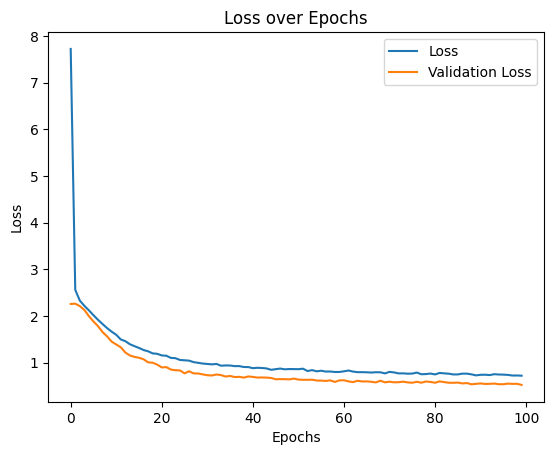

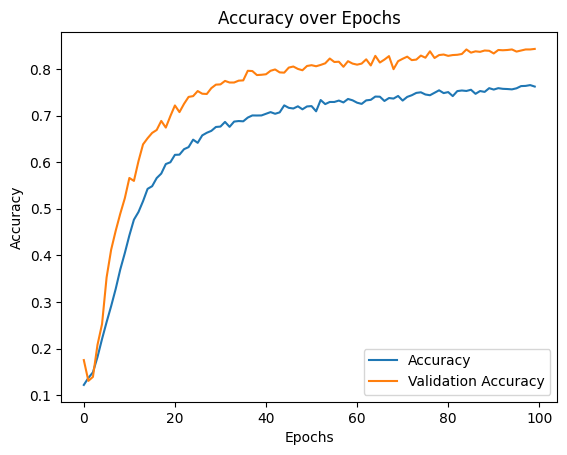

In [30]:
showAccVallLossPlt(history)

In [31]:
history2 = model.fit(
          x_train, 
          y_train, 
          batch_size=32, 
          epochs=200,
          validation_data=(x_test, y_test),
         )

Epoch 1/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7541 - loss: 0.7260 - val_accuracy: 0.8363 - val_loss: 0.5491
Epoch 2/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7525 - loss: 0.7431 - val_accuracy: 0.8329 - val_loss: 0.5401
Epoch 3/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7617 - loss: 0.7282 - val_accuracy: 0.8306 - val_loss: 0.5685
Epoch 4/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7656 - loss: 0.7292 - val_accuracy: 0.8311 - val_loss: 0.5497
Epoch 5/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7722 - loss: 0.7027 - val_accuracy: 0.8380 - val_loss: 0.5586
Epoch 6/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7768 - loss: 0.7156 - val_accuracy: 0.8460 - val_loss: 0.5472
Epoch 7/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7595 - loss: 0.7179 - val_accuracy: 0.8506 - val_loss: 0.5191
Epoch 8/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7642 - loss: 0.7223 - val_accu

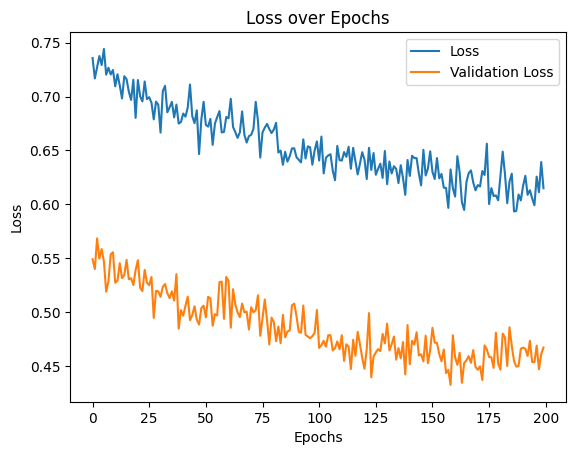

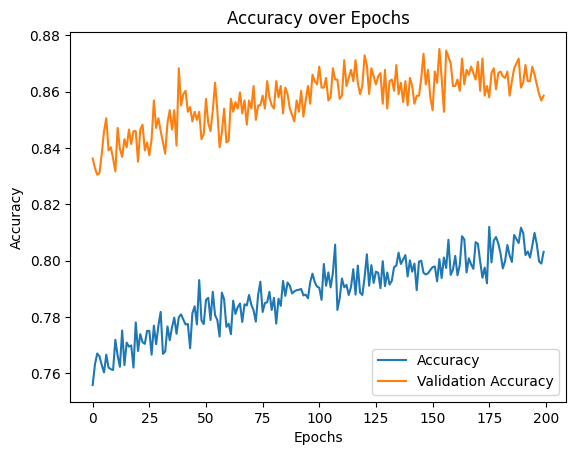

In [32]:
showAccVallLossPlt(history2)

Epoch 1/180
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8114 - loss: 0.6015 - val_accuracy: 0.8746 - val_loss: 0.4381
Epoch 2/180
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8236 - loss: 0.5471 - val_accuracy: 0.8666 - val_loss: 0.4337
Epoch 3/180
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8191 - loss: 0.6081 - val_accuracy: 0.8678 - val_loss: 0.4525
Epoch 4/180
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8230 - loss: 0.5641 - val_accuracy: 0.8735 - val_loss: 0.4331
Epoch 5/180
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8146 - loss: 0.5580 - val_accuracy: 0.8769 - val_loss: 0.4180
Epoch 6/180
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8215 - loss: 0.5538 - val_accuracy: 0.8844 - val_loss: 0.4212
Epoch 7/180
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8152 - loss: 0.5784 - val_accuracy: 0.8735 - val_loss: 0.4294
Epoch 8/180
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8227 - loss: 0.5544 - val_accu

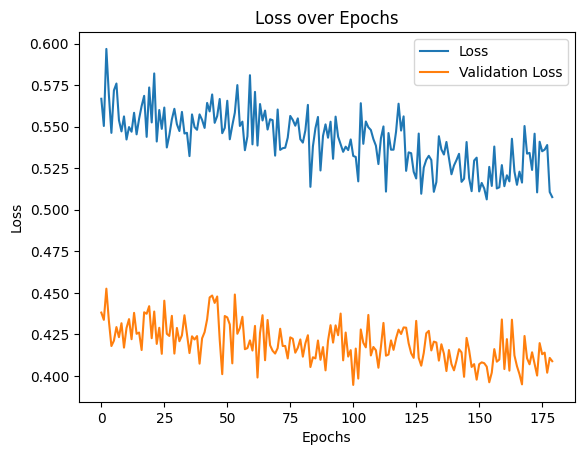

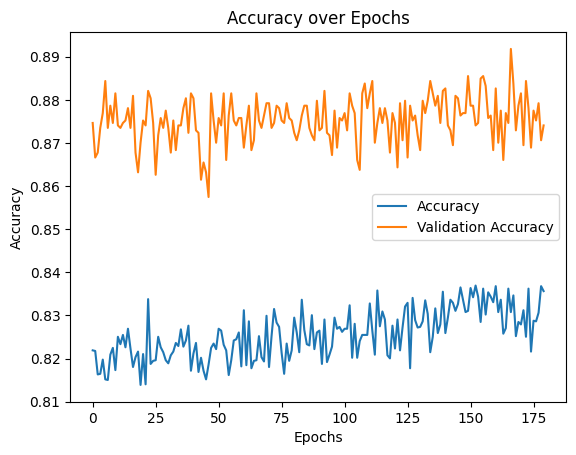

In [33]:
history3 = model.fit(
          x_train, 
          y_train, 
          batch_size=64, 
          epochs=180,
          validation_data=(x_test, y_test),
         )
showAccVallLossPlt(history3)

CNN

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input

num_labels = y.shape[1]
modelConv = Sequential([
    Input(shape=(50, 1)), 
    
    Conv1D(64, 3, activation='relu'), 
    MaxPooling1D(2),  

    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),

    Conv1D(256, 3, activation='relu'),
    MaxPooling1D(2),

    Flatten(),  

    Dense(128, activation='relu'),  
    Dropout(0.5),
    Dense(num_labels, activation='softmax')  
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           6,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 418,592 (1.60 MB)

 Trainable params: 139,530 (545.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 279,062 (1.06 MB)

Epoch 1/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2788 - loss: 2.1204 - val_accuracy: 0.5890 - val_loss: 1.2441
Epoch 2/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5476 - loss: 1.3422 - val_accuracy: 0.7287 - val_loss: 0.8784
Epoch 3/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6717 - loss: 0.9730 - val_accuracy: 0.7934 - val_loss: 0.6723
Epoch 4/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7621 - loss: 0.7340 - val_accuracy: 0.8082 - val_loss: 0.6094
Epoch 5/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8018 - loss: 0.5969 - val_accuracy: 0.8294 - val_loss: 0.5343
Epoch 6/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8334 - loss: 0.4911 - val_accuracy: 0.8598 - val_loss: 0.4687
Epoch 7/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8696 - loss: 0.4039 - val_accuracy: 0.8706 - val_loss: 0.4254
Epoch 8/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8760 - loss: 0.3664 - val_accu

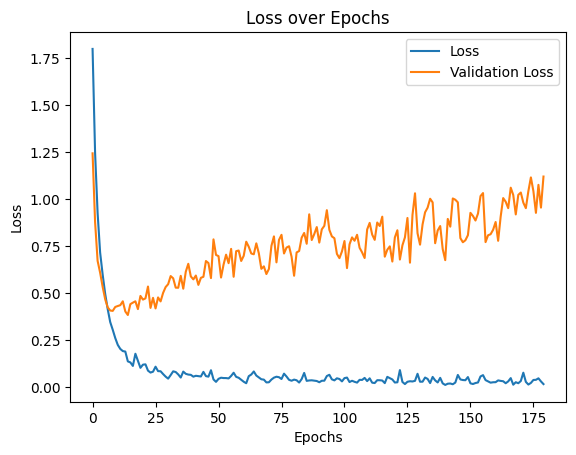

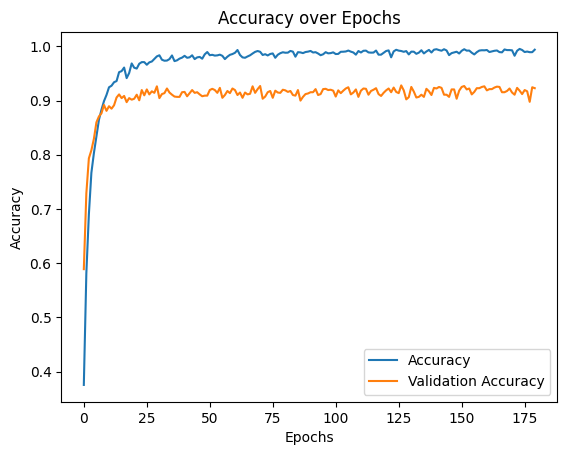

In [35]:
modelConv.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
history4 = modelConv.fit(
          x_train, 
          y_train, 
          epochs=180,
          validation_data=(x_test, y_test),
         )
showAccVallLossPlt(history4)

Epoch 1/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9936 - loss: 0.0256 - val_accuracy: 0.9164 - val_loss: 0.9936
Epoch 2/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9950 - loss: 0.0167 - val_accuracy: 0.9227 - val_loss: 0.9386
Epoch 3/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9938 - loss: 0.0187 - val_accuracy: 0.9073 - val_loss: 1.1551
Epoch 4/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9907 - loss: 0.0369 - val_accuracy: 0.9176 - val_loss: 0.9326
Epoch 5/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9889 - loss: 0.0380 - val_accuracy: 0.9193 - val_loss: 0.9435
Epoch 6/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9933 - loss: 0.0195 - val_accuracy: 0.9187 - val_loss: 1.1239
Epoch 7/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9919 - loss: 0.0307 - val_accuracy: 0.9130 - val_loss: 1.0460
Epoch 8/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9895 - loss: 0.0391 - val_accu

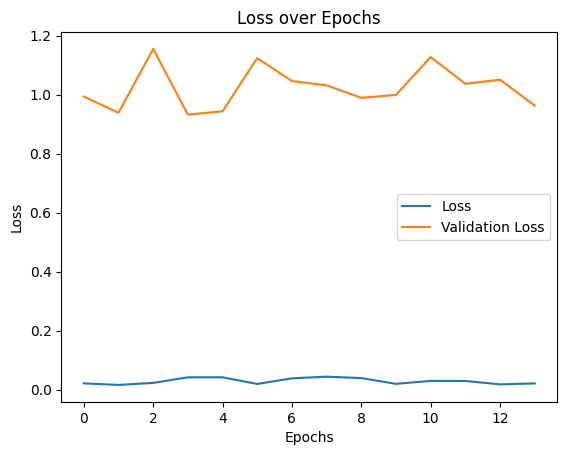

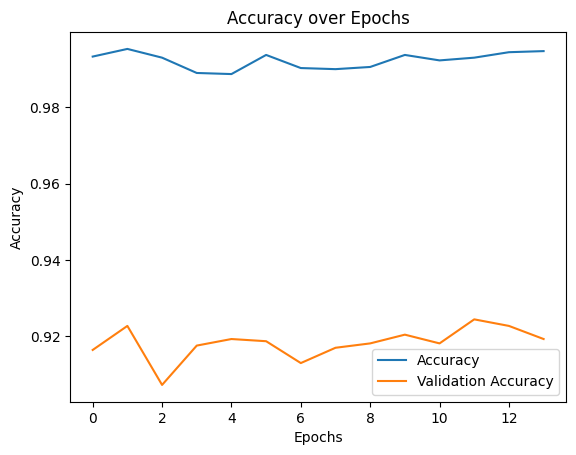

In [36]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history5=modelConv.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=180, callbacks=[early_stopping])
showAccVallLossPlt(history5)

In [37]:
from tensorflow.keras.layers import BatchNormalization

num_labels = y.shape[1]
modelConv2 = Sequential([
    Input(shape=(50, 1)), 
    
    Conv1D(64, 3, activation='relu'), 
    MaxPooling1D(2),
    BatchNormalization(),  #
    
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),
    BatchNormalization(),
    
    Conv1D(256, 3, activation='relu'),
    MaxPooling1D(2),
    BatchNormalization(),
    
    Flatten(),
    
    Dense(256, activation='relu'),  
    Dropout(0.5),
    Dense(128, activation='relu'),  
    Dropout(0.5),
    
    Dense(num_labels, activation='softmax')
])

modelConv2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
modelConv2.summary()


early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 48, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 24, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 24, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 22, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 11, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 11, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 9, 256)              │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 4, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 4, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 421,898 (1.61 MB)

 Trainable params: 421,002 (1.61 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.2827 - loss: 2.2024 - val_accuracy: 0.5547 - val_loss: 1.5175
Epoch 2/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5190 - loss: 1.4131 - val_accuracy: 0.6806 - val_loss: 0.9829
Epoch 3/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6513 - loss: 1.0680 - val_accuracy: 0.7642 - val_loss: 0.7693
Epoch 4/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6980 - loss: 0.9192 - val_accuracy: 0.7905 - val_loss: 0.6281
Epoch 5/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7552 - loss: 0.7483 - val_accuracy: 0.7304 - val_loss: 0.8438
Epoch 6/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8046 - loss: 0.6094 - val_accuracy: 0.8248 - val_loss: 0.5490
Epoch 7/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8126 - loss: 0.5757 - val_accuracy: 0.8449 - val_loss: 0.4851
Epoch 8/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8482 - loss: 0.4773 - val_accu

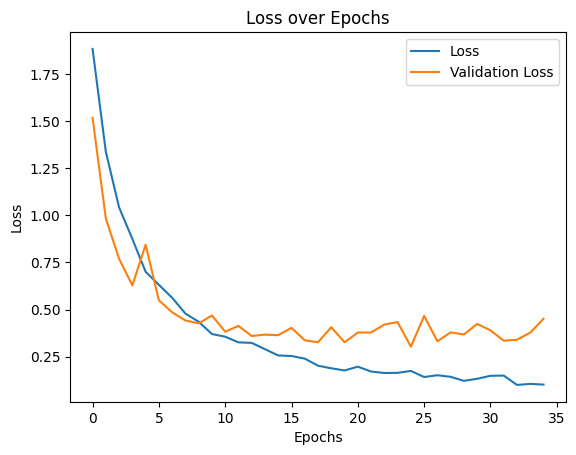

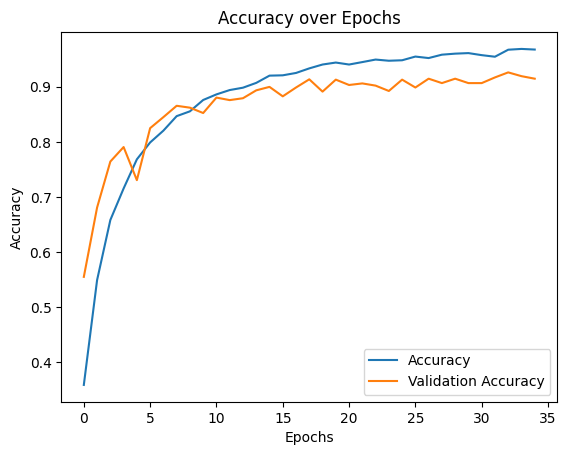

In [38]:
history6 = modelConv2.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=200, batch_size=32,callbacks=[early_stopping])
showAccVallLossPlt(history6)

Epoch 1/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9511 - loss: 0.1447 - val_accuracy: 0.9124 - val_loss: 0.3536
Epoch 2/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9421 - loss: 0.1892 - val_accuracy: 0.9027 - val_loss: 0.3947
Epoch 3/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9511 - loss: 0.1458 - val_accuracy: 0.9130 - val_loss: 0.3787
Epoch 4/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9582 - loss: 0.1298 - val_accuracy: 0.8964 - val_loss: 0.3989
Epoch 5/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9637 - loss: 0.1193 - val_accuracy: 0.9107 - val_loss: 0.3463
Epoch 6/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9517 - loss: 0.1524 - val_accuracy: 0.9153 - val_loss: 0.3169
Epoch 7/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9606 - loss: 0.1172 - val_accuracy: 0.9187 - val_loss: 0.3428
Epoch 8/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9599 - loss: 0.1202 - val_accu

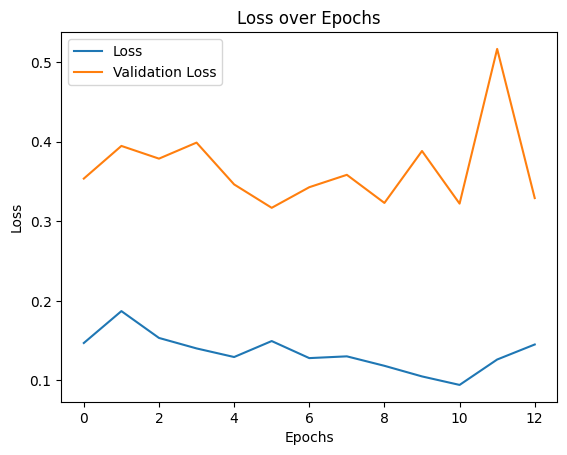

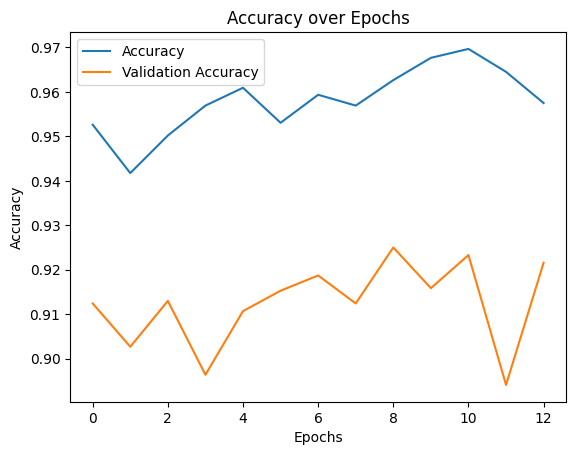

In [39]:
early_stop2 = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
history7 = modelConv2.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=200, batch_size=32,callbacks=[early_stop2])
showAccVallLossPlt(history7)

In [44]:
def extract_feature(file_name):
    audio_data, sample_rate = librosa.load(file_name, sr=22050, res_type='soxr_vhq')  # Avoids resampy
    fea = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=50)
    scaled = np.mean(fea.T, axis=0)
    return np.array([scaled])

def print_prediction(file_name):
    pred_fea = extract_feature(file_name) 
    pred_vector = np.argmax(model.predict(pred_fea), axis=-1)
    pred_class = le.inverse_transform(pred_vector)
    print("The predicted class is:", pred_class[0], '\n') 

In [45]:
df

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


In [49]:
print_prediction('./archive (4)/fold1/101415-3-0-3.wav')
ipd.Audio('./archive (4)/fold1/101415-3-0-3.wav')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
The predicted class is: dog_bark 



In [55]:
print_prediction('./archive (4)/fold10/100648-1-2-0.wav')
ipd.Audio('./archive (4)/fold10/100648-1-2-0.wav')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
The predicted class is: street_music 



In [51]:
print_prediction('./archive (4)/fold3/103199-4-0-3.wav')
ipd.Audio('./archive (4)/fold3/103199-4-0-3.wav')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
The predicted class is: drilling 



In [56]:
!pip install resampy

Defaulting to user installation because normal site-packages is not writeable


In [57]:
import resampy